In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/breast/data.csv")
data = data.drop(columns=['Unnamed: 32'])
data = data.drop(columns=['id'])
data.loc[data["diagnosis"] == 'M' , "diagnosis"] = 0
data.loc[data["diagnosis"] == 'B' , "diagnosis"] = 1
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data.head()
data.shape

(569, 31)

In [5]:
target = 'diagnosis'

In [6]:
X = data.drop(columns=[target])
y = data[target]
y=y.astype('int')

In [7]:
y_series = pd.Series(y)

# Calculate the class distribution
class_distribution = y_series.value_counts(normalize=True) * 100

print(class_distribution)

1    62.741652
0    37.258348
Name: diagnosis, dtype: float64


In [7]:
#model_ctgan = CTGANSynthesizer(epochs=1)
#model_ctgan = DPCTGANSynthesizer(verbose=True, epochs=25)
model_ctgan = FPGANSynthesizer(verbose=True, epochs=2000)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data, rate=0.75)

Epoch 1, Loss G: -0.1286,Loss D:  0.0064
Epoch 2, Loss G: -0.1285,Loss D: -0.0355
Epoch 3, Loss G: -0.1297,Loss D: -0.1096
Epoch 4, Loss G: -0.1210,Loss D: -0.1600
Epoch 5, Loss G: -0.1201,Loss D: -0.2133
Epoch 6, Loss G: -0.1134,Loss D: -0.2616
Epoch 7, Loss G: -0.1127,Loss D: -0.3224
Epoch 8, Loss G: -0.1069,Loss D: -0.4382
Epoch 9, Loss G: -0.1086,Loss D: -0.5488
Epoch 10, Loss G: -0.1136,Loss D: -0.6949
Epoch 11, Loss G: -0.1189,Loss D: -0.7656
Epoch 12, Loss G: -0.1278,Loss D: -0.8101
Epoch 13, Loss G: -0.1592,Loss D: -0.7915
Epoch 14, Loss G: -0.1768,Loss D: -0.7915
Epoch 15, Loss G: -0.2096,Loss D: -0.7643
Epoch 16, Loss G: -0.2431,Loss D: -0.9768
Epoch 17, Loss G: -0.2801,Loss D: -0.7567
Epoch 18, Loss G: -0.3465,Loss D: -0.7607
Epoch 19, Loss G: -0.3535,Loss D: -0.4637
Epoch 20, Loss G: -0.3911,Loss D: -0.3063
Epoch 21, Loss G: -0.4093,Loss D: -0.1934
Epoch 22, Loss G: -0.4133,Loss D: -0.0331
Epoch 23, Loss G: -0.4342,Loss D: -0.2581
Epoch 24, Loss G: -0.4722,Loss D:  0.1063
E

([array(-0.0129986, dtype=float32),
  array(-0.01282647, dtype=float32),
  array(-0.01376147, dtype=float32),
  array(-0.00164141, dtype=float32),
  array(-0.00089325, dtype=float32),
  array(0.00785097, dtype=float32),
  array(0.00838472, dtype=float32),
  array(0.01547989, dtype=float32),
  array(0.01209263, dtype=float32),
  array(0.00551066, dtype=float32),
  array(-0.00395061, dtype=float32),
  array(-0.01669428, dtype=float32),
  array(-0.06018244, dtype=float32),
  array(-0.0841959, dtype=float32),
  array(-0.1298319, dtype=float32),
  array(-0.17640926, dtype=float32),
  array(-0.22703634, dtype=float32),
  array(-0.31786698, dtype=float32),
  array(-0.32899612, dtype=float32),
  array(-0.38115278, dtype=float32),
  array(-0.40703532, dtype=float32),
  array(-0.41475233, dtype=float32),
  array(-0.44501922, dtype=float32),
  array(-0.4975071, dtype=float32),
  array(-0.48813105, dtype=float32),
  array(-0.47119665, dtype=float32),
  array(-0.52046317, dtype=float32),
  array(-0

In [8]:
from utils.utils import save_models
save_models(model_ctgan,'075fpgan2000', 'breast_cancer')

In [9]:
from utils.utils import load_models
model_ctgan = load_models('075fpgan2000', 'breast_cancer')

In [10]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [11]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame

In [12]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.14087082]


In [13]:
samples.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.990261,0.262365,0.608337,0.255859,0.135924,0.526650,0.153077,0.528492,0.246891,0.103542,...,0.042478,0.183451,0.213558,0.046337,0.496209,0.130524,0.123098,0.217516,0.304451,0.305374
1,0.966399,0.194780,0.735561,0.815294,0.098466,0.404588,0.386726,0.956469,0.262185,0.382029,...,0.141619,0.298241,0.038084,0.239297,0.166357,0.873422,0.423640,0.839509,0.239350,0.243350
2,-0.088475,0.423844,0.525394,0.310113,0.349960,0.301049,0.313061,0.291566,0.398181,0.168121,...,0.762634,0.273282,0.931657,0.077887,0.561232,0.365731,0.320160,0.570254,0.080899,0.253072
3,0.963837,0.367279,0.365948,0.271599,0.134197,0.260989,0.203110,0.053924,0.266963,0.451104,...,0.161982,-0.011854,0.233820,0.183130,0.481740,0.230238,-0.097016,0.141465,-0.040746,0.039591
4,0.905127,0.287909,0.093918,0.315871,0.073991,-0.154812,0.183984,0.039633,0.241859,0.560559,...,0.123937,0.020973,0.296081,0.161095,0.201160,0.272610,0.059185,0.131938,0.032029,0.016068


## Fidelity

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample = False)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample = False)

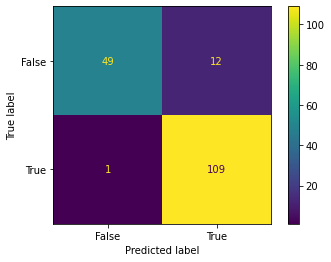

In [15]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [16]:
percentage = eval_fidelity(rr_pred, fr_pred)

In [17]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.9590643274853801
Accuracy of synthetic data:  0.9064327485380117


In [18]:
from utils.fidelity import get_roc_auc

rr_score = get_roc_auc(y_test, rr_pred)
fr_score = get_roc_auc(y_test, fr_pred)
print("ROC AUC of real data: ", rr_score)
print("ROC AUC of synthetic data: ", fr_score)

ROC AUC of real data:  0.9515917056074766
ROC AUC of synthetic data:  0.8781396028037383


## Final plot

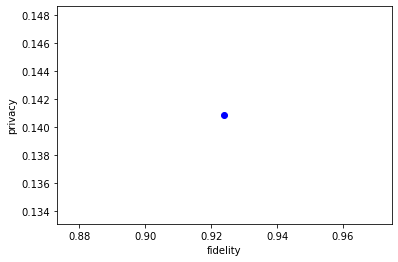

0.9239766081871345 [0.14087082]


In [19]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)